In [1]:
import numpy as np, os
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

#GPU 사용 설정, -1이면 CPU 사용
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# # 메모리 최소 할당
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# with tf.Session(config=config) as sess:

# # 메모리 40% 할당
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# sess = tf.Session(config=config) as sess:

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:  # gpu가 있다면, 용량 한도를 5GB로 설정
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [96]:
path = '/project/LSH/'
fi = pd.read_csv('./data/df_all_best_type.csv')
fi_d1 = pd.read_csv(path + 'df_d1d5_best.csv')
fi_d6 = pd.read_csv(path + 'df_d6d10_best.csv')
COLS = list(pd.read_csv(path + 'total_data_7727.csv')['ITEMID'].sort_values().unique())
model = tf.keras.models.load_model(path + 'model/(LSTM_best_4068)seed42-05-0.5029.hdf5')

In [97]:
fi_d1.sort_values('feature')

,feature,baseline_bce,bce,diff
5,0,1.014362,1.011114,-0.003247
2624,50803,1.014362,1.015100,0.000739
3724,50804,1.014362,1.017607,0.003245
2148,50805,1.014362,1.014638,0.000276
3883,50806,1.014362,1.019179,0.004817
...,...,...,...,...
2126,78112001103,1.014362,1.014625,0.000263
854,79511050204,1.014362,1.014254,-0.000108
4027,87701071218,1.014362,1.023990,0.009628
1323,87701083336,1.014362,1.014352,-0.000009


In [98]:
pre_list = fi[fi['Type']=='PRE'].feature.to_list()
lab_list = fi[fi['Type']=='LAB'].feature.to_list()
pro_list = fi[fi['Type']=='PRO'].feature.to_list()

def what_type(x):
    if x in pre_list:
        return 'PRE'
    elif x in lab_list:
        return 'LAB'
    elif x in pro_list:
        return 'PRO'
    else:
        return 'ERROR'

# FI에 ReLU 적용

In [99]:
#relu 함수 정의
def relu(x):
    return np.maximum(0, x)

In [100]:
tmp = fi_d1.copy()
tmp['diff'] = tmp['diff'].apply(lambda x:relu(x))
relu_fi = tmp[['feature', 'diff']].sort_values('diff', ascending=False)

In [103]:
relu_fi.sort_values('feature')

,feature,diff
5,0,0.000000
2624,50803,0.000739
3724,50804,0.003245
2148,50805,0.000276
3883,50806,0.004817
...,...,...
2126,78112001103,0.000263
854,79511050204,0.000000
4027,87701071218,0.009628
1323,87701083336,0.000000


# Prepare Data

In [8]:
import random    
seed_num = 42
random.seed(seed_num)
path = '/project/LSH/'
X = np.load(path + 'x_(7727,10,4068).npy')
y = np.load(path + 'y_(7727,1).npy')

idx = list(range(len(X)))
random.shuffle(idx)


i = round(X.shape[0]*0.8)
X_train, y_train = X[idx[:i],:,:], y[idx[:i]]
X_test, y_test = X[idx[i:],:,:], y[idx[i:]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6182, 10, 4068), (6182,), (1545, 10, 4068), (1545,))

In [9]:
base_pred = np.mean(model.predict(X_test))
base_pred

0.6369324

# 0 to 1 - D-1~5

In [53]:
result = []
model = tf.keras.models.load_model('/project/LSH/model/(LSTM_best_4068)seed42-05-0.5029.hdf5')
for i in tqdm(range(X_test.shape[2])):
    save_cols = X_test[:,:,i].copy()
    X_test[:,-5:,i] = 1
    # predict - base_pred
    pred = model.predict(X_test)
    value = np.mean(pred) - base_pred
    sign = 1 if value>=0 else -1
    result.append({'feature' : int(COLS[i]), 'diff' : value, 'sign' : sign})
    #값 복원
    X_test[:,:,i] = save_cols

  0%|          | 0/4068 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
near_df = pd.DataFrame(result)
near_df_ori = near_df.copy()
near_df.sort_values('diff', ascending=False)

,feature,diff,sign
2195,409606211,0.163837,1
1276,74606211,0.127455,1
1081,67434504,0.121142,1
2744,10019055302,0.110931,1
982,54817525,0.109244,1
...,...,...,...
37,50889,-0.090138,-1
162,51200,-0.090340,-1
3818,63323016101,-0.091983,-1
469,4003822,-0.097162,-1


In [125]:
near_df

,feature,diff,sign
0,0,-0.012654,-1
1,50803,-0.014815,-1
2,50804,0.035180,1
3,50805,-0.026609,-1
4,50806,0.042676,1
...,...,...,...
4063,78112001103,-0.041465,-1
4064,79511050204,-0.001754,-1
4065,87701071218,0.067929,1
4066,87701083336,0.004660,1


## 최종 Score

In [104]:
near_result = near_df.feature.to_frame()
#relu_fi 정렬
relu_fi_near = relu_fi.sort_values('feature').reset_index(drop=True)
relu_fi_near

,feature,diff
0,0,0.000000
1,50803,0.000739
2,50804,0.003245
3,50805,0.000276
4,50806,0.004817
...,...,...
4063,78112001103,0.000263
4064,79511050204,0.000000
4065,87701071218,0.009628
4066,87701083336,0.000000


In [105]:
near_result = near_df.feature.to_frame()
#정렬, reset index
relu_fi_near = relu_fi.sort_values('feature').reset_index(drop=True)
near_df['feature'] = near_df['feature'].astype(int)
near_df = near_df.sort_values('feature').reset_index(drop=True)

near_result['score'] = relu_fi_near['diff'] * near_df['sign']
near_result = near_result.sort_values('score', ascending=False).reset_index(drop=True)

#save
near_result.to_csv('./data/method2_nearscore.csv', index=False)

near_result

,feature,score
0,409606211,0.044651
1,74606211,0.028581
2,67434504,0.024894
3,54817525,0.022155
4,10019055302,0.021081
...,...,...
4063,182138167,-0.008059
4064,63323016101,-0.008225
4065,50889,-0.008520
4066,4003822,-0.009620


In [107]:
near_result.sort_values('feature')

,feature,score
3024,0,-0.000000
3813,50803,-0.000739
308,50804,0.003245
3626,50805,-0.000276
169,50806,0.004817
...,...,...
3614,78112001103,-0.000263
1925,79511050204,-0.000000
39,87701071218,0.009628
1921,87701083336,0.000000


# 0 to 1 - D-6~10

In [122]:
tmp = fi_d6.copy()
tmp['diff'] = tmp['diff'].apply(lambda x:relu(x))
relu_fi = tmp[['feature', 'diff']].sort_values('diff', ascending=False)

In [124]:
relu_fi.sort_values('feature')

,feature,diff
1,0,0.000000
3930,50803,0.000890
3628,50804,0.000546
3727,50805,0.000613
565,50806,0.000000
...,...,...
3461,78112001103,0.000454
2115,79511050204,0.000011
152,87701071218,0.000000
1160,87701083336,0.000000


In [34]:
import random    
seed_num = 42
random.seed(seed_num)
path = '/project/LSH/'
X = np.load(path + 'x_(7727,10,4068).npy')
y = np.load(path + 'y_(7727,1).npy')

idx = list(range(len(X)))
random.shuffle(idx)


i = round(X.shape[0]*0.8)
X_train, y_train = X[idx[:i],:,:], y[idx[:i]]
X_test, y_test = X[idx[i:],:,:], y[idx[i:]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6182, 10, 4068), (6182,), (1545, 10, 4068), (1545,))

In [35]:
result = []
for i in tqdm(range(X_test.shape[2])):
    save_cols = X_test[:,:,i].copy()
    X_test[:,:5,i] = 1
    # predict - base_pred
    pred = model.predict(X_test)
    value = np.mean(pred) - base_pred
    sign = 1 if value>=0 else -1
    result.append({'feature' : str(COLS[i]), 'diff' : value, 'sign' : sign})
    #값 복원
    X_test[:,:,i] = save_cols

  0%|          | 0/4068 [00:00<?, ?it/s]

In [37]:
away_df = pd.DataFrame(result)
away_df_ori = away_df.copy()
away_df.sort_values('diff', ascending=False)

,feature,diff,sign
2195,409606211,0.043069,1
1276,74606211,0.030764,1
982,54817525,0.030322,1
1081,67434504,0.029405,1
2744,10019055302,0.027365,1
...,...,...,...
1815,182138167,-0.023320,-1
162,51200,-0.023503,-1
37,50889,-0.024924,-1
469,4003822,-0.025266,-1


## 최종 Score

In [113]:
away_result = away_df.feature.to_frame()
#정렬, reset index
relu_fi_away = relu_fi.sort_values('feature').reset_index(drop=True)
away_df['feature'] = away_df['feature'].astype(int)
away_df = away_df.sort_values('feature').reset_index(drop=True)

away_result['score'] = relu_fi_away['diff'] * away_df['sign']
away_result = away_result.sort_values('score', ascending=False).reset_index(drop=True)

#save
away_result.to_csv('./data/method2_awayscore.csv', index=False)

away_result

,feature,score
0,61553015311,0.000481
1,51301,0.000320
2,54008826,0.000309
3,487980125,0.000296
4,51256,0.000287
...,...,...
4063,517293025,-0.001881
4064,182138167,-0.001932
4065,51200,-0.001937
4066,50889,-0.001982


In [114]:
away_result.sort_values('feature', ascending=True).reset_index(drop=True)

,feature,score
0,0,-0.000000
1,50803,-0.000890
2,50804,-0.000546
3,50805,-0.000613
4,50806,0.000000
...,...,...
4063,78112001103,-0.000454
4064,79511050204,-0.000011
4065,87701071218,0.000000
4066,87701083336,0.000000


# 역전되는 Feature 탐색
원거리(away_result['score']) - 근거리(near_result['score']) 

In [115]:
near_result = pd.read_csv('./data/method2_nearscore.csv')
away_result = pd.read_csv('./data/method2_awayscore.csv')

In [116]:
near_result = near_result.sort_values('feature').reset_index(drop=True)
away_result = away_result.sort_values('feature').reset_index(drop=True)

In [117]:
final_result = near_result.feature.to_frame()
final_result['diff_score'] = away_result['score'] - near_result['score']

final_result = final_result.sort_values('diff_score', ascending=False).reset_index(drop=True)
final_result['Type'] = final_result['feature'].apply(lambda x:what_type(int(x)))
final_result.to_csv('./data/method2_finalscore.csv', index=False)


In [126]:
final_result.sort_values('feature')

,feature,diff_score,Type
741,0,0.000000,PRE
1616,50803,-0.000152,LAB
3821,50804,-0.003792,LAB
2271,50805,-0.000337,LAB
3898,50806,-0.004817,LAB
...,...,...,...
1757,78112001103,-0.000191,PRE
968,79511050204,-0.000011,PRE
4028,87701071218,-0.009628,PRE
863,87701083336,0.000000,PRE


# Visualization

In [119]:
### 사망/퇴원 환자 df 분리

X = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')
# 컬럼이름 로드
COLS = list(pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].sort_values().unique())

#death_index
d_index = np.where(y==1)[0]
#survive_index (퇴원 환자)
s_index = np.where(y==0)[0]

#사망/퇴원 환자 분리
d_X = X[d_index]
s_X = X[s_index]

result = []
result_s = []
#day - 10일
for d in range(10):
    #4068 - ITEM
    for f in range(d_X.shape[-1]):
        d_sum = d_X[:,d,f].sum()/d_X.shape[0]
        s_sum = s_X[:,d,f].sum()/s_X.shape[0]
        result.append({'cols':COLS[f], 'day':10-d,'per':d_sum})
        result_s.append({'cols':COLS[f], 'day':10-d,'per':s_sum})
        
d_df = pd.DataFrame(result).sort_values(['cols','day']).reset_index(drop=True)
s_df = pd.DataFrame(result_s).sort_values(['cols','day']).reset_index(drop=True)
d_df.shape, s_df.shape

((40680, 3), (40680, 3))

In [120]:
def visualization(top10_list):
    plt.figure(figsize = (13,12), dpi=150)
    for i, f in enumerate(top10_list):
        plt.subplot(4,3,1+i)
        plt.title(f)
        ax = sns.lineplot(data = d_df[d_df['cols']==int(f)], x = 'day', y='per', label='사망')
        ax = sns.lineplot(data = s_df[s_df['cols']==int(f)], x = 'day', y='per', label='퇴원')
        ax.invert_xaxis()
        ax.legend(loc='upper left')
    plt.tight_layout()

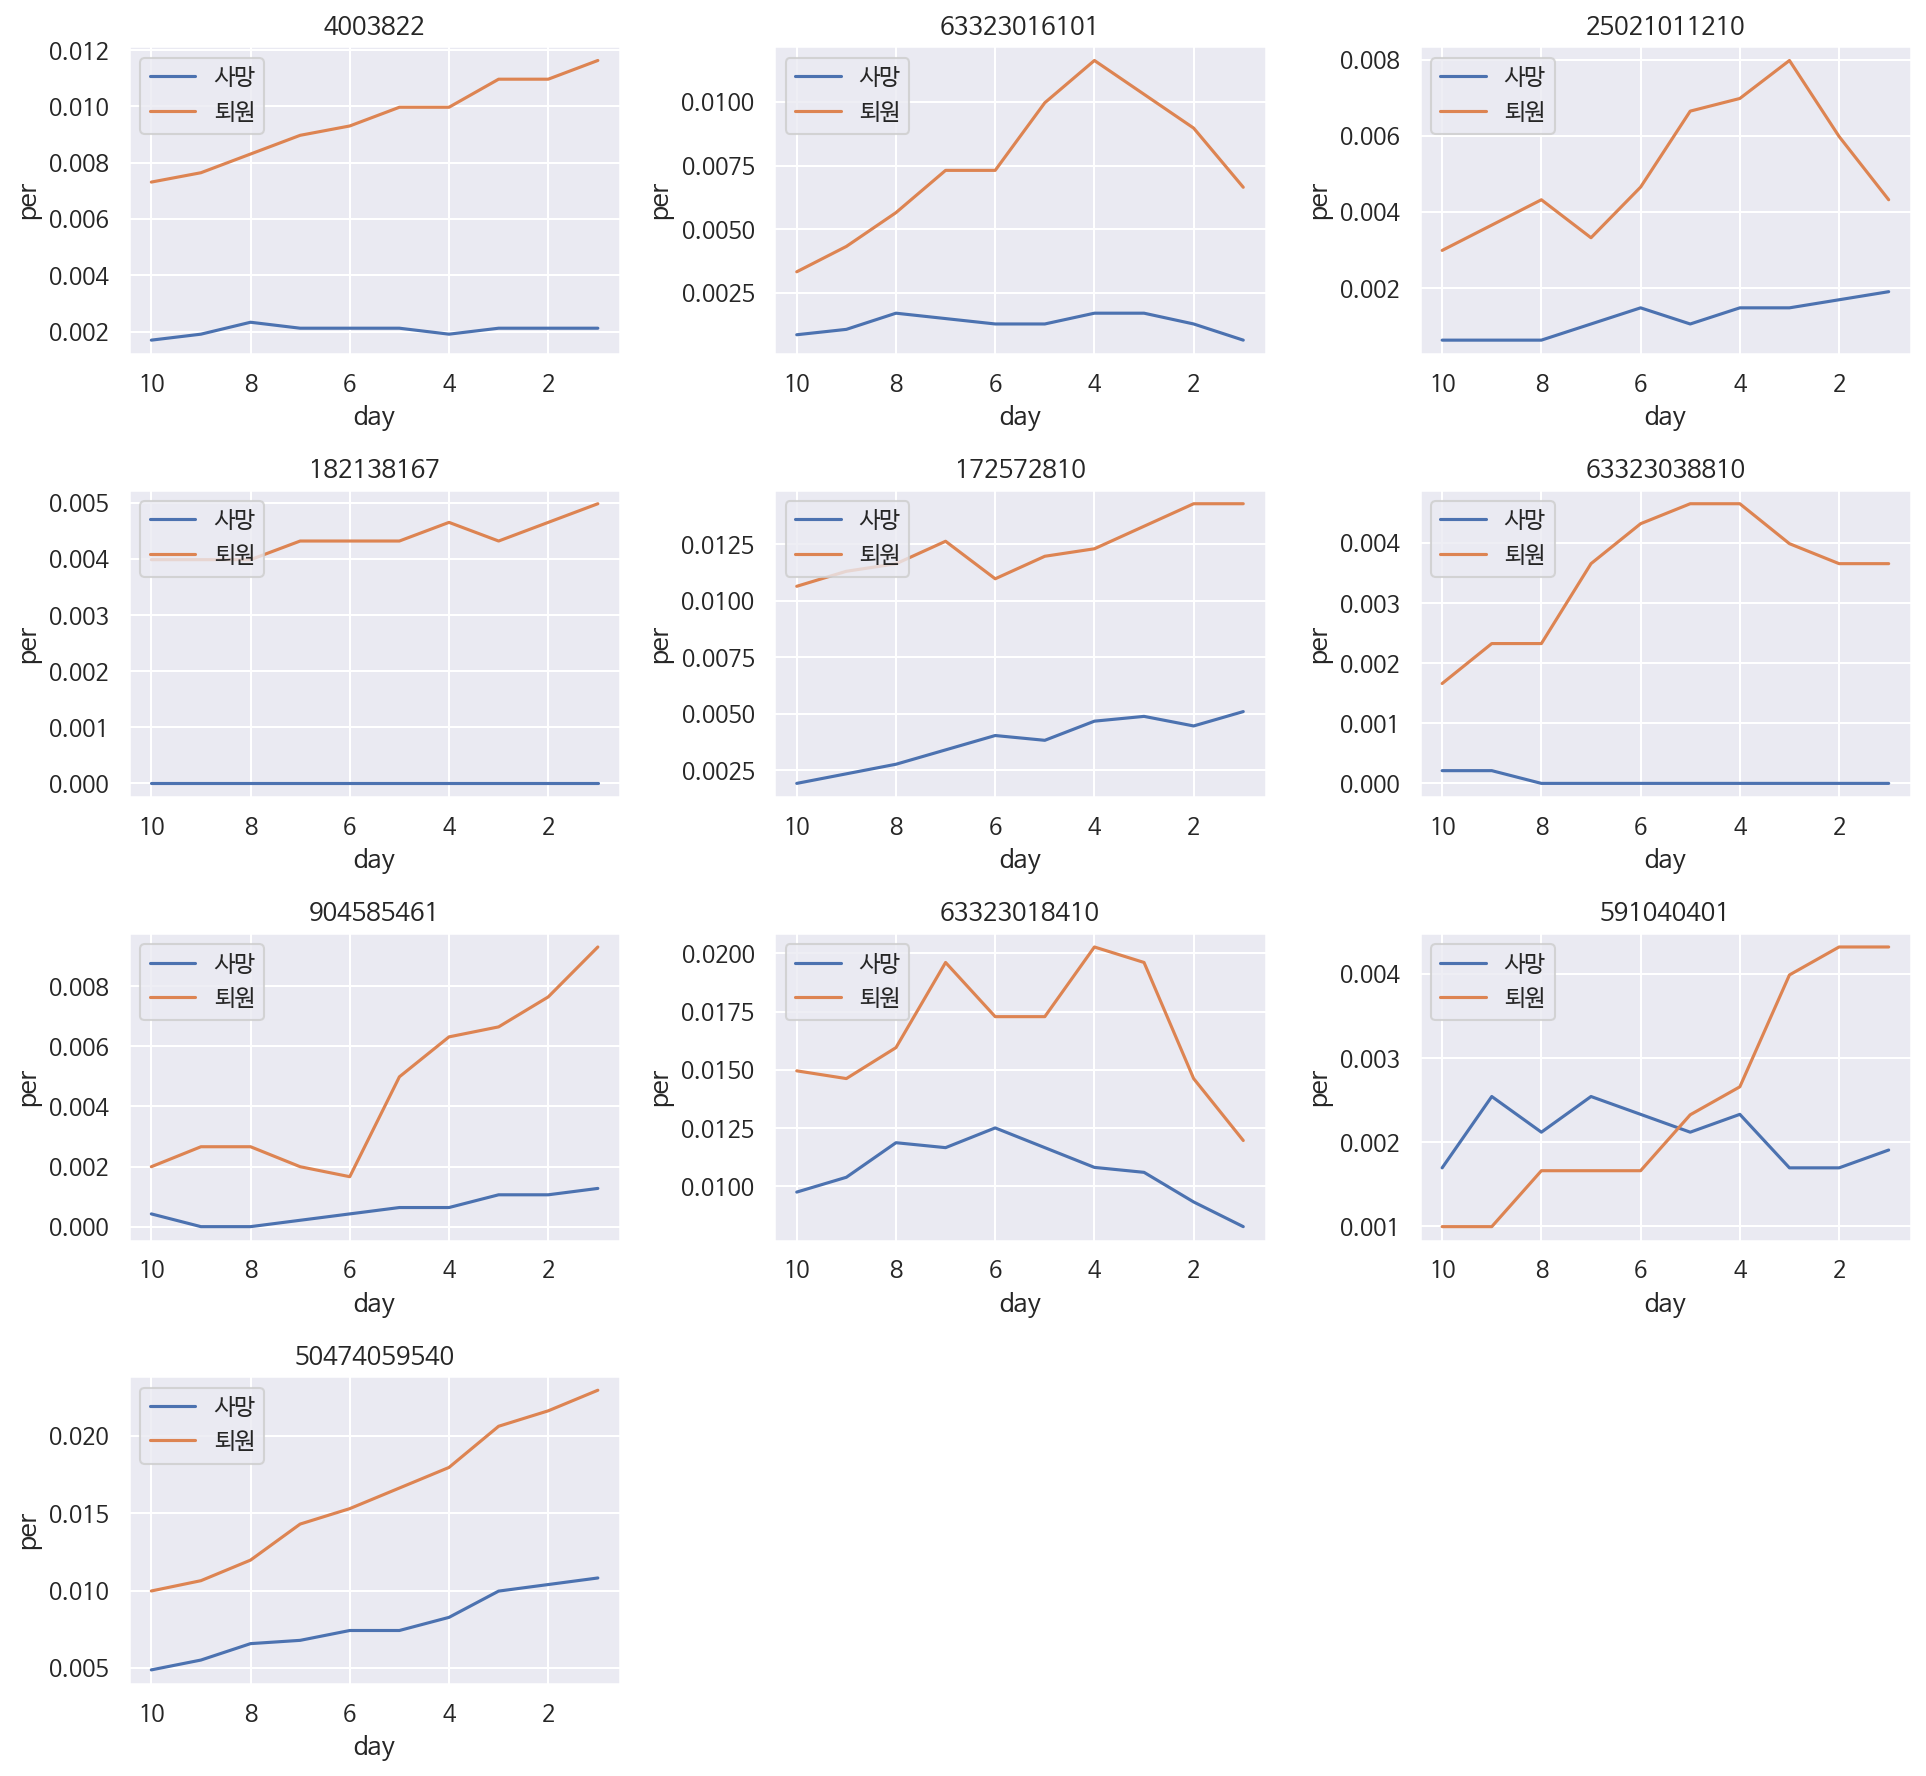

In [121]:
visualization(final_result[final_result['Type']=='PRE'].feature[:10])

# 확인

In [29]:
near = pd.read_csv('./data/method2_nearscore.csv').sort_values('feature').reset_index(drop=True)
away = pd.read_csv('./data/method2_awayscore.csv').sort_values('feature').reset_index(drop=True)

In [30]:
near.score

0      -0.000000
1      -0.002118
2      -0.003495
3       0.001575
4      -0.005405
          ...   
4063   -0.002014
4064   -0.000000
4065   -0.013409
4066    0.000000
4067   -0.000887
Name: score, Length: 4068, dtype: float64

In [31]:
away.score

0      -0.000000
1      -0.002926
2      -0.003238
3      -0.001892
4       0.000239
          ...   
4063   -0.003865
4064   -0.001255
4065    0.007261
4066    0.001689
4067    0.010964
Name: score, Length: 4068, dtype: float64

In [32]:
sum(near.score - away.score)

-0.14152860641479525